In [65]:
import sys
sys.path.append('/data2/youngju/kimst24/')
import os
import argparse
import pickle
# from splinecam import splinecam
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torchvision.utils import make_grid
import torch.nn.functional as F
import torchvision.transforms.functional as tF

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as mpl_Polygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mpl_colors
import mpl_toolkits.mplot3d as a3

import random
import numpy as np
from networkx import draw as nxdraw
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.patches as mpatches
from utils.load_dataset import *
from utils.visualization import *
from utils.config_funcs import *
from tqdm import tqdm

In [66]:
parser = argparse.ArgumentParser()
parser.add_argument("--data-path", type=str, default="/data/CUB_200_2011/images")
parser.add_argument("--model-path", type=str, default="/data2/youngju/kimst24/outputs_backup/clf_checkpoints/2024-05-01_204226/clf_ep-24_lr-0.001_val-acc-0.7630.pth")
parser.add_argument("--pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/train")
parser.add_argument("--q_pickle-path", type=str, default="/data2/youngju/kimst24/outputs/get_config/test")
parser.add_argument("--q_th", type=int, default=200)
parser.add_argument("--seed", type=int, default=0)
parser.add_argument("--batch-size", type=int, default=512)
parser.add_argument("--num-pickle", type=int, default=7)
parser.add_argument("--device", type=str, default="cuda:5")
parser.add_argument("--train-ratio", type=float, default=0.7)
parser.add_argument("--resolution", type=int, default=100)


args = parser.parse_args(args=[])

In [67]:
SEED = args.seed
MEAN = (0.485, 0.456, 0.406)
STD = (0.229, 0.224, 0.225)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

inv_normalize = transforms.Normalize(
    mean=[-m/s for m,s in zip(MEAN, STD)],
    std=[1/s for s in STD]
)

In [68]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, 200)
model.load_state_dict(torch.load(args.model_path))
model = model.to(args.device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
# train_loader, val_loader, test_loader = get_CUB_loaders(args.data_path, args.batch_size, args.train_ratio, train=True)

In [70]:
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    ac_total = torch.sign(pickle.load(fr))
with open(f"{args.pickle_path}/total_activation.pkl","rb") as fr:
    h_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_eq.pkl","rb") as fr:
    eq_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_x.pkl","rb") as fr:
    x_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_y.pkl","rb") as fr:
    y_total = pickle.load(fr)
with open(f"{args.pickle_path}/total_preds.pkl","rb") as fr:
    preds_total = pickle.load(fr).cpu().detach()
with open(f"{args.pickle_path}/total_probs.pkl","rb") as fr:
    probs_total = pickle.load(fr).cpu().detach()

In [71]:
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_ac_total = torch.sign(pickle.load(fr))
with open(f"{args.q_pickle_path}/total_activation.pkl","rb") as fr:
    q_h_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_eq.pkl","rb") as fr:
    q_eq_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_x.pkl","rb") as fr:
    q_x_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_y.pkl","rb") as fr:
    q_y_total = pickle.load(fr)
with open(f"{args.q_pickle_path}/total_preds.pkl","rb") as fr:
    q_preds_total = pickle.load(fr).cpu().detach()
with open(f"{args.q_pickle_path}/total_probs.pkl","rb") as fr:
    q_probs_total = pickle.load(fr).cpu().detach()

In [72]:
def get_plane(img1, img2, img3):
    ''' Calculate the plane (basis vecs) spanned by 3 images
    Input: 3 image tensors of the same size
    Output: two (orthogonal) basis vectors for the plane spanned by them, and
    the second vector (before being made orthogonal)
    '''
    a = img2 - img1 
    b = img3 - img1 
    a_norm = torch.dot(a.flatten(), a.flatten()).sqrt()
    a = a / a_norm
    first_coef = torch.dot(a.flatten(), b.flatten())
    b_orthog = b - first_coef * a
    b_orthog_norm = torch.dot(b_orthog.flatten(), b_orthog.flatten()).sqrt()
    b_orthog = b_orthog / b_orthog_norm 
    second_coef = torch.dot(b.flatten(), b_orthog.flatten())
    coords = [[0,0], [a_norm,0], [first_coef, second_coef]]
    return a, b_orthog, b, coords # a, b_orthog 직교 (둘다 normalized 완료)

In [73]:
class plane_dataset(torch.utils.data.Dataset):
    def __init__(self, base_img, vec1, vec2, coords, resolution=0.2,
                    range_l=.1, range_r=.1):
        self.base_img = base_img
        self.vec1 = vec1
        self.vec2 = vec2
        self.coords = coords
        self.resolution = resolution
        x_bounds = [coord[0] for coord in coords]
        y_bounds = [coord[1] for coord in coords]

        self.bound1 = [torch.min(torch.tensor(x_bounds)), torch.max(torch.tensor(x_bounds))]
        self.bound2 = [torch.min(torch.tensor(y_bounds)), torch.max(torch.tensor(y_bounds))]

        len1 = self.bound1[-1] - self.bound1[0]
        len2 = self.bound2[-1] - self.bound2[0]

        list1 = torch.linspace(self.bound1[0] - range_l*len1, self.bound1[1] + range_r*len1, int(resolution))
        list2 = torch.linspace(self.bound2[0] - range_l*len2, self.bound2[1] + range_r*len2, int(resolution))

        self.grid = torch.meshgrid([list1,list2])

        self.coefs1 = self.grid[0].flatten()
        self.coefs2 = self.grid[1].flatten()

    def __len__(self):
        return self.coefs1.shape[0]

    def __getitem__(self, idx):
        return self.base_img + self.coefs1[idx] * self.vec1 + self.coefs2[idx] * self.vec2

In [74]:
def make_planeloader(images):
    a, b_orthog, b, coords = get_plane(images[0], images[1], images[2])

    planeset = plane_dataset(images[0], a, b_orthog, coords, resolution=500, range_l=0.1, range_r=0.1) # 500x500

    planeloader = torch.utils.data.DataLoader(
        planeset, batch_size=args.batch_size, shuffle=False, num_workers=0)
    return planeloader

In [75]:
def make_pred_for_grid(model, space_name, loader, device, flow_model=None):
    model.eval()
    predicted_labels = []
    if space_name == 'x':
        with torch.no_grad():
            for batch_idx, inputs in enumerate(loader):
                inputs = inputs.to(device)
                outputs = model(inputs)
                for output in outputs:
                    predicted_labels.append(output)
    else:
        with torch.no_grad():
            for batch_idx, inputs in enumerate(loader):
                inputs = inputs.to(device)
                outputs = model(flow_model.decode(inputs))
                for output in outputs:
                    predicted_labels.append(output)
    return predicted_labels

In [76]:
def imscatter(x, y, image, ax=None, zoom=1):
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [77]:
def produce_plot_alt(path, preds, planeloader, images, labels, MEAN, STD, temp=5.0):
    from matplotlib import cm
    from matplotlib.colors import LinearSegmentedColormap
    col_map = cm.get_cmap('tab10')
    cmaplist = [col_map(i) for i in range(col_map.N)]
    classes = ['0', '1', '2', '3', '4',
                   '5', '6', '7', '8', '9']

    cmaplist = cmaplist[:len(classes)]
    col_map = LinearSegmentedColormap.from_list('custom_colormap', cmaplist, N=len(classes))
    fig, ax1 = plt.subplots()
    import torch.nn as nn
    preds = torch.stack((preds))
    preds = nn.Softmax(dim=1)(preds) #/ temp)
    val = torch.max(preds,dim=1)[0].cpu().numpy()
    class_pred = torch.argmax(preds, dim=1).cpu().numpy()
    x = planeloader.dataset.coefs1.cpu().numpy()
    y = planeloader.dataset.coefs2.cpu().numpy()
    label_color_dict = dict(zip([*range(10)], cmaplist))

    color_idx = [label_color_dict[label] for label in class_pred] # class_pred
    scatter = ax1.scatter(x, y, c=color_idx, alpha=val, s=0.1)
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in label_color_dict.values()]
    legend1 = plt.legend(markers, classes, numpoints=1,bbox_to_anchor=(1.01, 1))
    ax1.add_artist(legend1)
    coords = planeloader.dataset.coords

    dm = torch.tensor(MEAN)[:, None, None]
    ds = torch.tensor(STD)[:, None, None]
    for i, image in enumerate(images):
        # import ipdb; ipdb.set_trace()
        #img = torch.clamp(image * ds + dm, 0, 1)
        img = inv_normalize(image)
        img = img.cpu().numpy().transpose(1,2,0)
        if img.shape[0] > 32:
            from PIL import Image
            img = img*255
            img = img.astype(np.uint8)
            img = Image.fromarray(img).resize(size=(32, 32))
            img = np.array(img)

        coord = coords[i]
        imscatter(coord[0], coord[1], img, ax1)

    red_patch = mpatches.Patch(color =cmaplist[labels[0]] , label=f'{classes[labels[0]]}')
    blue_patch = mpatches.Patch(color =cmaplist[labels[1]], label=f'{classes[labels[1]]}')
    green_patch = mpatches.Patch(color =cmaplist[labels[2]], label=f'{classes[labels[2]]}')
    plt.legend(handles=[red_patch, blue_patch, green_patch], loc='upper center', bbox_to_anchor=(0.5, 1.05),
              ncol=3, fancybox=True, shadow=True)
    plt.title('Hyperplane in X-space')
    
    if not os.path.exists(path):
        os.makedirs(path)
        
    if path is not None:
        img_dir = '/'.join([p for p in (path.split('/'))[:-1]])
        os.makedirs(img_dir, exist_ok=True)
        #os.makedirs(path.split, exist_ok=True)
        plt.savefig(f'{path}/x-space.png',bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.close(fig)
    return

In [78]:
q_idx = 439#1389 #814
local_samples = get_local_nearest_idx_euc(q_h_total[q_idx], h_total, th=args.q_th)

In [79]:
three_points_x = torch.stack([q_x_total[q_idx], x_total[local_samples[0]], x_total[local_samples[1]]])
three_points_preds = torch.tensor([q_preds_total[q_idx].item(), preds_total[local_samples[0]].item(), preds_total[local_samples[1]].item()])
three_points_y = torch.tensor([q_y_total[q_idx].item(), y_total[local_samples[0]].item(), y_total[local_samples[1]].item()])

In [80]:
images = three_points_x.float()
labels = three_points_y

In [81]:
a, b_orthog, b, coords = get_plane(images[0],
                                    images[1],
                                    images[2])
planeloader = make_planeloader(images)

In [82]:
# 2D coordinates of three anchor points
coords_ = np.array([
    (0, 0), 
    (coords[1][0].item(), 0), 
    (coords[2][0].item(), coords[2][1].item()),
])

coords_ = torch.from_numpy(coords_).type(torch.float32)
coords, coords_

([[0, 0], [tensor(812.2866), 0], [tensor(330.8981), tensor(557.2587)]],
 tensor([[  0.0000,   0.0000],
         [812.2866,   0.0000],
         [330.8981, 557.2587]]))

In [83]:
T = torch.stack([a, b_orthog, images[0]]).flatten(start_dim=1).T.double()
T.shape

torch.Size([150528, 3])

In [84]:
xx, yy = planeloader.dataset.grid
grid = torch.stack([xx, yy])
grid = grid.reshape(-1,2)

# upper and lower bounds
xlow, ylow = grid[:, 0].min(), grid[:, 1].min()
xhigh, yhigh = grid[:, 0].max(), grid[:, 1].max()

In [85]:
domain = torch.tensor([
    [xlow, ylow],
    [xlow, yhigh],
    [xhigh, yhigh],
    [xhigh, ylow],
    [xlow, ylow]
])
print(domain)
domain += np.sign(domain)*1.5
poly = domain.double()
print (domain)

tensor([[-81.2287, -81.2287],
        [-81.2287, 893.5152],
        [893.5152, 893.5152],
        [893.5152, -81.2287],
        [-81.2287, -81.2287]])
tensor([[-82.7287, -82.7287],
        [-82.7287, 895.0152],
        [895.0152, 895.0152],
        [895.0152, -82.7287],
        [-82.7287, -82.7287]])


In [86]:
xx, yy = np.meshgrid(np.linspace(xlow, xhigh, args.resolution), np.linspace(ylow, yhigh, args.resolution))
inp = torch.from_numpy(np.stack([xx, yy], axis=2).reshape(-1, 2)).to(args.device).double()

In [87]:
inp_h_dim = ((T[...,:-1] @ inp.cpu().detach().T + T[...,-1:]).T).reshape(10000, 3, 224, 224)

In [88]:
loader = DataLoader(inp_h_dim, batch_size= 64)

In [89]:
with torch.no_grad():
    outputs_list = []
    for batch in tqdm(loader):
        output = model(batch.float().to(args.device))
        pred = output.argmax(dim=1)
        outputs_list.append(pred)
out_class = torch.cat(outputs_list)

100%|██████████| 157/157 [00:11<00:00, 14.07it/s]


In [144]:
classes = []
for i, c in enumerate(list(np.unique(np.array(out_class.cpu().detach())))):
    classes.append(f'{c}')

In [145]:
classes_total = classes.copy()
if f'{labels[0].item()}' not in classes:
    classes_total.append(f'{labels[0].item()}')

In [146]:
classes_total = np.sort(list(map(int, classes_total)))
classes_total = list(map(str, classes_total))

In [147]:
class_idx_dict = {string : i for i,string in enumerate(classes_total)}

/tmp/ipykernel_97899/3895840832.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  col_map = cm.get_cmap('prism') # flags
/tmp/ipykernel_97899/3895840832.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=label_color_dict[class_idx_dict[f'{label}']], marker='o', edgecolor='black', s=8)
/tmp/ipykernel_97899/3895840832.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

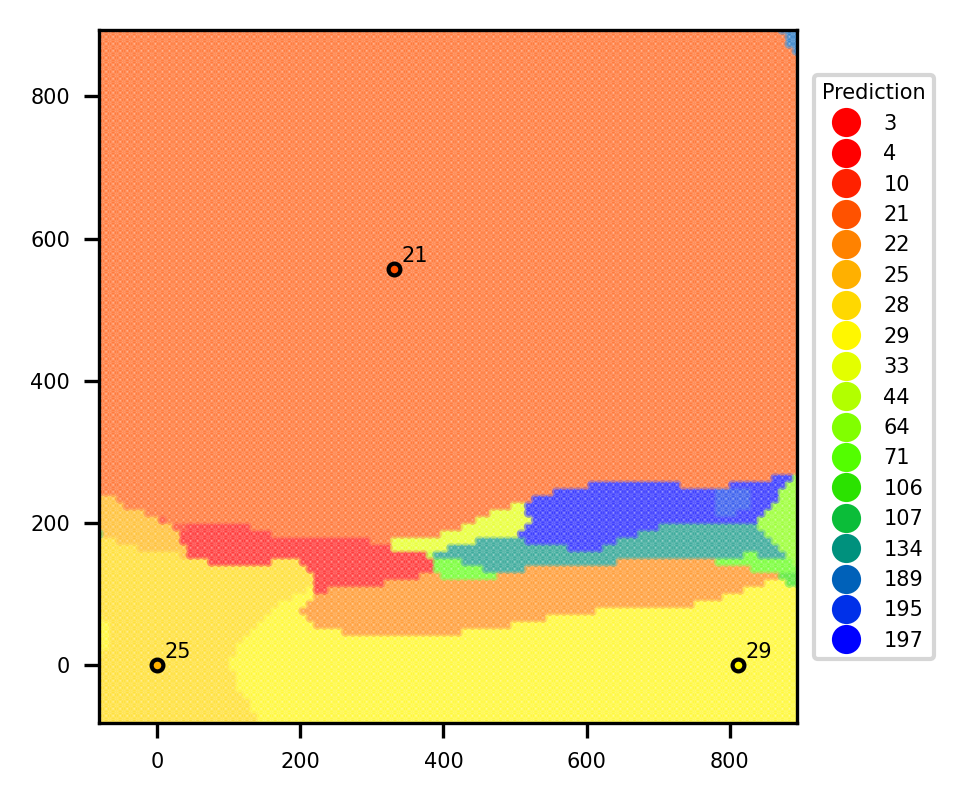

In [148]:
inp = inp.cpu()
figsize = (3, 3)
fig, ax = plt.subplots(1,figsize=figsize, dpi=300)
ax.set_xlim(xlow, xhigh)
ax.set_ylim(ylow, yhigh)

from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

col_map = cm.get_cmap('prism') # flags
cmaplist = [col_map(i) for i in range(col_map.N)]
# classes = ['0', '1', '2', '3', '4',
#                 '5', '6', '7', '8', '9']
cmaplist = cmaplist[:len(classes_total)]
col_map = LinearSegmentedColormap.from_list('custom_colormap', cmaplist, N=len(classes_total))
label_color_dict = dict(zip([*range(len(classes_total))], cmaplist))

inp_color = [label_color_dict[class_idx_dict[f'{i}']] for i in list(np.array(out_class.cpu().detach()))]

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in label_color_dict.values()]
legend1 = plt.legend(markers, classes_total, numpoints=1, bbox_to_anchor=(1.01, 0.95), fontsize=5, title='Prediction', title_fontsize=5) # , title='Test'
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
# legend1.set_title('Test', size=5)

ax.scatter(inp[:, 0], inp[:, 1], 
        c=inp_color, alpha=0.4, s=2)

coords = planeloader.dataset.coords
for i, image in enumerate(images):
        coord = coords[i]
        label = labels[i].item()
        x = torch.tensor(coord[0]).clone().cpu().detach()
        y = torch.tensor(coord[1]).clone().cpu().detach()
        ax.scatter(x, y, c=label_color_dict[class_idx_dict[f'{label}']], marker='o', edgecolor='black', s=8)
        plt.text(x+10, y+10, label, fontsize=5)


# for i, image in enumerate(images):
#         img = inv_normalize(image)
#         img = img.cpu().detach().numpy().transpose(1,2,0)
#         from PIL import Image
#         img = img*255
#         img = img.astype(np.uint8)
#         img = Image.fromarray(img).resize(size=(28, 28))
#         img = np.array(img)

#         coord = coords[i]
#         imscatter(torch.tensor(coord[0]).clone().cpu().detach(), torch.tensor(coord[1]).clone().cpu().detach(), img, ax)